In [130]:
# change pdb chain id

pdb_fpath = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/structure/8A0E_epi/AF_DHSK329A_PLDDT70.pdb'
chain_revise = {'D': 'B'}
new_lines = []

with open(pdb_fpath, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('ATOM'):
            chain_id = line[21]
            if chain_id in chain_revise.keys():
                line = line[:21] + chain_revise[chain_id] + line[22:]
        new_lines.append(line)

with open(pdb_fpath, 'w') as f:
    f.writelines(new_lines)

### docking post processing ###

1. run hdock and run_createpl.sh, the created docking file will be transfered to root_dir/hdock_files
2. revise the model pdb files, rename chain id, merge receptor and ligand records

### prepare model input ###
1. output chain fasta files for each protein
2. output esm2 embedding (maximum length of 1022)


In [1]:
import os
import shutil

In [17]:
### revise the Hdock model pdb file ###
protein_name = 'model'
N_model = 1000

for folder in os.listdir('/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/hdock_files'):
    print('processing', folder)
    src_path = f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/hdock_files/{folder}'
    dst_path = f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/structure/{folder}'

    dst_file = [f'{protein_name}_{i}' for i in range(1, N_model+1)]

    if not os.path.exists(f'{dst_path}'):
        os.makedirs(f'{dst_path}')
    for pdb in dst_file:
        with open(f'{src_path}/{pdb}.pdb', 'r') as f, open(f'{dst_path}/{pdb.upper()}_REVISED.pdb', 'w') as out:
            chain_id = ord('A')  # ASCII value of 'A'
            prev_residue_index = None

            for line in f:
                if line.startswith('ATOM'):
                    line = line[:-1] + ' 1.00  0.00           ' + line[13] + '\n'

                elif line.startswith('HEADER rec.pdb'):
                    line = line.replace('rec.pdb', f'{pdb}.pdb')
                elif line.startswith('HEADER lig') or line.startswith('SHEET') or line.startswith('HELIX') or line.startswith('CONECT'):
                    continue

                out.write(line)

processing 1UGH
processing 6DJL
processing 8F7A
processing 6SB0
processing 6THL
processing 1UGH_epi
processing 6DJL_epi
processing 8F7A_epi
processing 6SB0_epi
processing 6THL_epi
processing 8A0E
processing 8A0E_epi


In [7]:
### output fasta file for esm2 ###
import os
import sys
sys.path.append('/home/lwang/AI-HDX-main/ProteinComplex_HDX_prediction/BiLSTM+GAT_v2/pepGraph_generation/tool')
from predataprocess import get_pdb_seq
from Bio import PDB
import warnings
warnings.filterwarnings("ignore")

root_dir = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock'
src_dir = f'/home/lwang/models/HDOCKlite-v1.1/pdb'
fail_list = []

pdb_list = os.listdir(src_dir)
for pdb_name in pdb_list:
    pdb_fname = pdb_name.split('.')[0]
    #if pdb_fname.startswith('model'):
    #    continue
    print('start processing', f'{pdb_fname}')        
    if os.path.isfile(f'{src_dir}/{pdb_fname}.pdb'):
        #try:
        parser = PDB.PDBParser()
        filepath = f'{src_dir}/{pdb_fname}.pdb'
        structure = parser.get_structure('structure', filepath)
        chain_ids = list(structure.get_chains())
        for chain_id in chain_ids:
            chain_id = chain_id.get_id()
            if chain_id == 'Z': #skip the heteroatoms chain
                continue
            sequence, residue_indices = get_pdb_seq(structure, chain_id)
            if len(sequence) == 0:
                continue
            elif len(sequence) > 1022:
                print(f'{pdb_fname}_{chain_id} has more than 1022 residues:', len(sequence))
                
            if os.path.isdir(f'{root_dir}/fasta_files') == False:
                os.mkdir(f'{root_dir}/fasta_files')
            with open(f'{root_dir}/fasta_files/{pdb_fname.upper()}_{chain_id.upper()}.fasta', 'w') as f:
                f.write(f'>{pdb_fname}_{chain_id}\n')
                f.write(sequence)
        #except Exception as e:
        #    print(e)
        #    fail_list.append(pdb_fname+'_'+chain_id)
        #    continue
    else:
        print(f'{src_dir}/{pdb_fname}.pdb does not exist')
print(fail_list)

start processing 1UGH
start processing 1UGI
start processing 1AKZ
start processing 6DJL
start processing 6IXE


start processing 1OIX
start processing 8F7A
start processing AF_RAN_PLDDT70
start processing AF_IMP9_PLDDT70
AF_IMP9_PLDDT70_A has more than 1022 residues: 1023
start processing 6SB0
6SB0_Y has more than 1022 residues: 1314
start processing AF_RAPTOR_PLDDT70
AF_RAPTOR_PLDDT70_Y has more than 1022 residues: 1313
start processing AF_RAGS_PLDDT70
start processing 8A0E
start processing AF_ELF5A_PLDDT70
start processing AF_DHSK329A_PLDDT70
start processing 6THL
start processing AF_RTT_PLDDT70
start processing AF_BCD_PLDDT70
start processing revise_ChainId
/home/lwang/models/HDOCKlite-v1.1/pdb/revise_ChainId.pdb does not exist
[]


In [ ]:
# run DockQ to evaluate the quality of Hdock decoys
import sys
sys.path.append('/home/lwang/DockQ/src/DockQ/')
from DockQ_revised import main

import pickle
import numpy as np
from argparse import Namespace

def run_dockq(model_fpath, native_fpath, mapping):
    args = Namespace(
        model=model_fpath,
        native=native_fpath,
        capri_peptide=False,
        small_molecule=False,
        short=True,
        verbose=True,
        no_align=False,
        n_cpu=8,
        max_chunk=512,
        optDockQF1=False,
        allowed_mismatches=0,
        mapping=mapping,
    )
    return main(args)

root_dir = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/structure'
protein_name = '6SB0'
hdock_dir = f'{root_dir}/{protein_name}'
model_list = [f'MODEL_{i}_REVISED.pdb' for i in range(1, 1001)]

eval_result = []
for model in model_list:
    model_fpath = f'{hdock_dir}/{model}'
    native_fpath = f'{hdock_dir}/{protein_name[:4]}.pdb'
    mapping = 'CDY:CDY'
    best_result = run_dockq(model_fpath, native_fpath, mapping)

    result_dict = list(best_result.values())
    receptor_chain = mapping.split(':')[0][-1]

    result_dict = [item for item in result_dict if item['chain1'] == receptor_chain or item['chain2'] == receptor_chain]
    merged_result = {key: (result_dict[0][key] + result_dict[1][key]) / 2 for key in result_dict[0].keys() if isinstance(result_dict[0][key], (int, float))}
    eval_result.append(merged_result)

dockq_scores = np.array([result['DockQ'] for result in eval_result[:]])
irmsd_scores = np.array([result['irms'] for result in eval_result])
lrmsd_scores = np.array([result['Lrms'] for result in eval_result])

print(np.sum(dockq_scores >= 0.1))
print(np.sum(irmsd_scores <= 7))
print(np.sum(lrmsd_scores <= 20))

'''
with open(f'{hdock_dir}/{protein_name}_dockq.pkl', 'wb') as f:
    pickle.dump(eval_result, f)'''


### Prepare sub graphs and make prediciton 
1. run /home/lwang/models/HDX_LSTM/data/Latest_test/hdock/RUN_ESM2.sh
2. edit excel records
3. run pepgraph_preprocessing.py
4. run pepGraph_prediction.py

### Re-rank decoys based on HDX score and Hdock score

In [127]:
# pre-setting and load prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

protein_name = '6THL'
cluster_id = 1
HDX_fpath = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/HDX_files/PXD023434_revised.xlsx'

dfs = []
for i in range(1):
    fpath = f'/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/prediction_esm/HDX_pred_GVP1280_{protein_name}_cluster{cluster_id}_5A_esm_v{i}.csv'
    df = pd.read_csv(fpath)
    print(df.shape)
    dfs.append(df)
merged_df = pd.concat(dfs, axis=0)
average_df = merged_df.groupby(['Batch', 'Chain', 'Range', 'Y_True'])['Y_Pred'].mean().reset_index()

print(average_df.head())
print(average_df.shape)

(27051, 5)
  Batch  Chain    Range    Y_True    Y_Pred
0  6THL      0  126-137  0.148537  0.205643
1  6THL      0  129-137  0.290016  0.440701
2  6THL      0  148-158  0.168191  0.112495
3  6THL      0  175-182  0.422244  0.549419
4  6THL      0  188-195  0.089625  0.136284
(27051, 5)


In [112]:
# get average uptake from source HDX file
# return true_diff dictionary =  [Range]: diff
timepoints = [1.35, 2.85]
def get_true_diff(HDX_fpath, apo_states, complex_states, cluster_id):
    def get_weighted_uptake(HDX_df, protein, state, correction):
        temp_HDX_df = HDX_df[(HDX_df['state']==state) & (HDX_df['protein']==protein)]
        if cluster_id == 0:
            temp_HDX_df = temp_HDX_df[temp_HDX_df['log_t']<timepoints[0]]
        elif cluster_id == 1:
            temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']<timepoints[1]) & (temp_HDX_df['log_t']>=timepoints[0])]
        elif cluster_id == 2:
            temp_HDX_df = temp_HDX_df[(temp_HDX_df['log_t']>=timepoints[1])]
        else:
            raise ValueError('Invalid cluster_id')
        
        temp_HDX_df = temp_HDX_df.sort_values(by=['start', 'end'], ascending=[True, True])

        exposures = temp_HDX_df['exposure'].unique()
        unweighted_RFU = {time:{} for time in exposures}
        for time in exposures:
            for index, row in temp_HDX_df[temp_HDX_df['exposure']==time].iterrows():
                #chain_id = int(row['Chain'])
                unweighted_RFU[time][f'{row["start"]+correction}-{row["end"]+correction}'] = row['RFU']

        grouped = temp_HDX_df.groupby(['start', 'end'])
        weighted_uptake = grouped['RFU'].mean().to_numpy()/100
        unique_pairs = grouped.groups.keys()
        x_label = [f'{start+correction}-{end+correction}' for start, end in unique_pairs]

        return weighted_uptake, x_label, unweighted_RFU
    
    HDX_df = pd.read_excel(HDX_fpath)
    true_apo, true_complex = {}, {}
    apo_mtx, complex_mtx = {}, {}

    protein, state, correction = apo_states[0], apo_states[1], apo_states[2]
    uptake, label, U_apo_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
    for l, u in zip(label, uptake):
        true_apo[l] = u
    apo_mtx.update(U_apo_mtx)

    protein, state, correction = complex_states[0], complex_states[1], complex_states[2]
    uptake, label, U_complex_mtx = get_weighted_uptake(HDX_df, protein, state, correction)
    for l, u in zip(label, uptake):
        true_complex[l] = u
    complex_mtx.update(U_complex_mtx)

    true_diff = {}
    diff_mtx = {}
    for key in true_apo.keys():
        if key in true_complex:
            true_diff[key] = true_complex[key] - true_apo[key]
            diff_mtx[key] = {t: complex_mtx[t][key] - apo_mtx[t][key] for t in apo_mtx if key in apo_mtx[t] and key in complex_mtx[t]}
    
    print('Common peptides num:', len(true_diff.keys()))
    return true_diff, diff_mtx

('bcdFL', 'Bcd', 0, 'AF_BCD_PLDDT70') ('bcdFL', 'Bcd_Rtt', 0, '6THL')
Common peptides num: 49


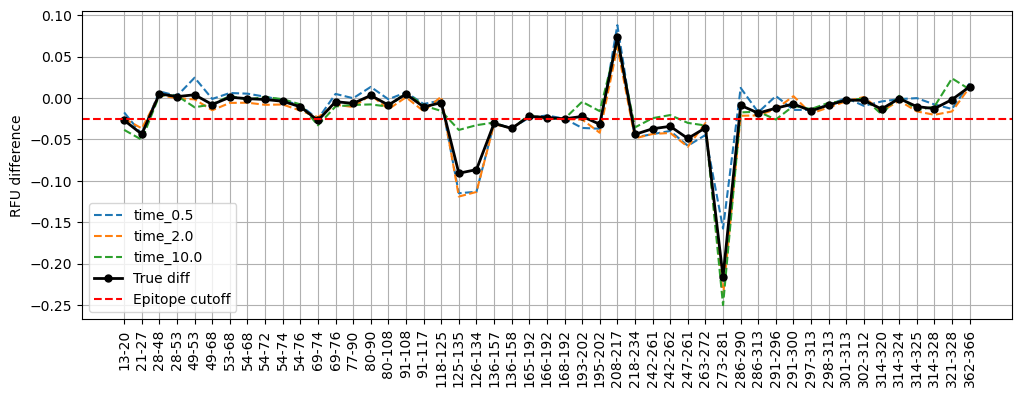

('rtt', 'Rtt', 0, 'AF_RTT_PLDDT70') ('rtt', 'Rtt_Bcd', 0, '6THL')
Common peptides num: 22


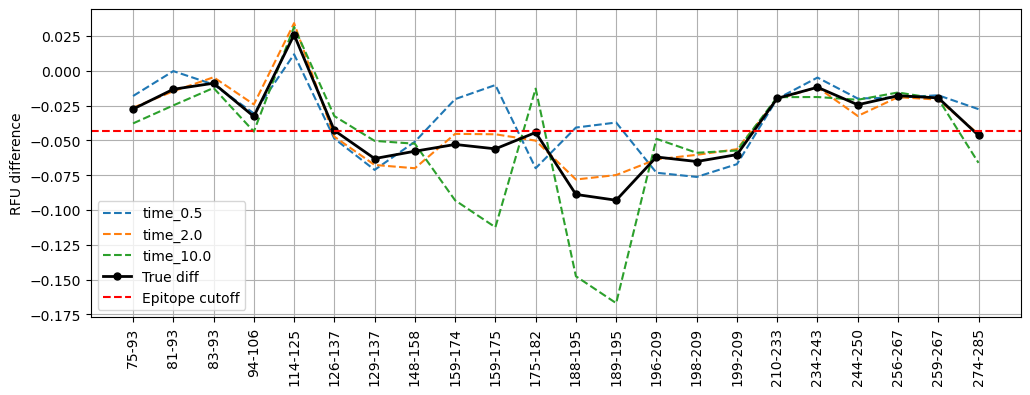

In [128]:
# plot HDX difference and find potential HDX epitopes
def plot_HDX_diff(true_diff, diff_mtx, size=(10, 6)):
    plt.figure(figsize=size)
    x_labels = list(true_diff.keys())
    x_positions = np.arange(len(x_labels))  # numerical positions for x-axis

    diff = np.array(list(true_diff.values()))
    diff_neg = diff[diff<0]
    mean_diff = np.mean(diff_neg)
    hdx_epitope_id = np.where(diff<mean_diff)[0]
    hdx_epitope_pep = [x_labels[i] for i in hdx_epitope_id]

    plt.xticks(x_positions, x_labels, rotation=90)  # apply labels with rotation for clarity
    all_times = set()
    for diffs in diff_mtx.values():
        all_times.update(diffs.keys())
    sorted_times = sorted(all_times, key=lambda x: float(x))
    for time in sorted_times:
        time_values = [diff_mtx[label].get(time, 0) / 100 for label in x_labels]
        plt.plot(x_positions, time_values, label=f'time_{time}', linestyle='--', alpha=1)
    plt.plot(x_positions, list(true_diff.values()), label='True diff', color='k', marker='o', linestyle='-', linewidth=2, markersize=5)
    plt.ylabel('RFU difference')
    plt.axhline(y=mean_diff, color='r', linestyle='--', label='Epitope cutoff')
    plt.grid(True)
    plt.legend()
    plt.show()

    return hdx_epitope_id, hdx_epitope_pep

summary_df = pd.read_excel('/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/test_data_AF.xlsx', sheet_name='hdock_modeling')
summary_df = summary_df.dropna(subset=['match_uni'])
summary_df = summary_df[(summary_df['note']==protein_name[:4])]
grouped = summary_df.groupby(['match_uni'])

apo_states, complex_states = [], []
for name, group in grouped:
    apo_group = group[group['complex_state'] == 'single']
    complex_group = group[group['complex_state'] == 'protein complex']
    apo_states.append((apo_group['protein'].values[0], apo_group['state'].values[0], apo_group['correction_value'].values[0], apo_group['structure_file'].values[0]))
    complex_states.append((complex_group['protein'].values[0], complex_group['state'].values[0], complex_group['correction_value'].values[0], complex_group['structure_file'].values[0]))


hdx_epitope_peps = []
hdx_true_diffs = []
for apo, complex in zip(apo_states, complex_states):
    print(apo, complex)
    true_diff, diff_mtx = get_true_diff(HDX_fpath, apo, complex, cluster_id)
    epitope_id, epitope_pep = plot_HDX_diff(true_diff, diff_mtx, size=(12,4))
    hdx_true_diffs.append(true_diff)
    hdx_epitope_peps.append(epitope_pep)

In [129]:
# HDX score calculation
from tqdm import tqdm

def root_mean_square_error(y_true, y_pred, error_limit):
    epsilon = 1e-12
    #weight = ((y_true+epsilon)/0.1) ** 2
    weight = 1
    return np.mean((weight * (((y_true - y_pred)/error_limit) ** 2)))

def prepare_data(complex_batch, apo_states, complex_states, hdx_true_diffs, hdx_epitope_peps=None):
    truth = []
    pred = []
    if hdx_epitope_peps is None:
        hdx_epitope_peps = [list(hdx_dict.keys()) for hdx_dict in hdx_true_diffs]
    for apo_state, complex_state, epitope_peps, hdx_dict in zip(apo_states, complex_states, hdx_epitope_peps, hdx_true_diffs):
        apo_batch = apo_state[-1]
        #complex_batch = complex_state[-1]
        apo_df = average_df[average_df['Batch']==apo_batch]
        complex_df = average_df[average_df['Batch']==complex_batch]

        for pep in epitope_peps:
            if pep in apo_df['Range'].values and pep in complex_df['Range'].values:
                pred_diff = complex_df.loc[complex_df['Range']==pep, 'Y_Pred'].values[0] - apo_df.loc[apo_df['Range']==pep, 'Y_Pred'].values[0]
                true_diff = hdx_dict[pep]
                truth.append(true_diff)
                pred.append(pred_diff)
    return np.array(truth), np.array(pred)

HDX_scores = []
complex_batch_list = [f'MODEL_{i}_REVISED' for i in range(1, 1001)]

for complex_batch in tqdm(complex_batch_list):
    y_true, y_pred = prepare_data(complex_batch, apo_states, complex_states, hdx_true_diffs, hdx_epitope_peps=hdx_epitope_peps)
    hdx_score = root_mean_square_error(y_true, y_pred, 0.5)
    HDX_scores.append(hdx_score)

  2%|▏         | 21/1000 [00:00<00:20, 48.08it/s]

100%|██████████| 1000/1000 [00:13<00:00, 73.59it/s]


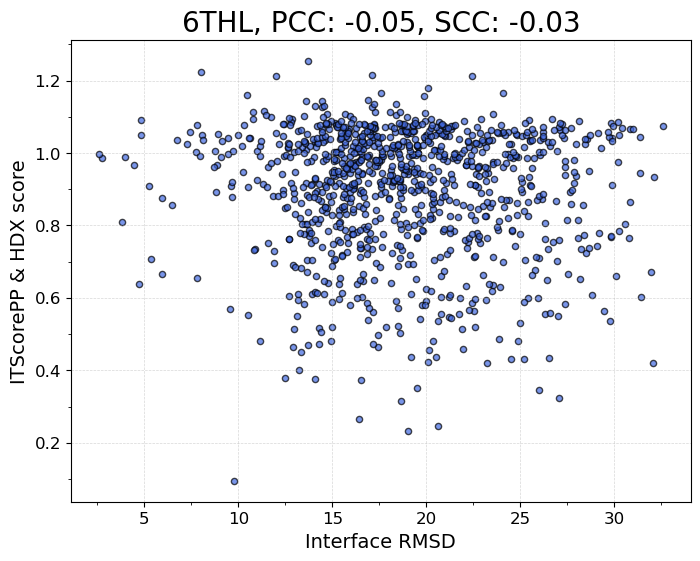

In [133]:
# load dockQ results and Hdock scores
import numpy as np
import pickle
from scipy.stats import pearsonr, spearmanr
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

def max_min_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_hdx_vs_dockq(HDX_scores, dockq_scores):
    plt.figure(figsize=(8, 6))
    plt.ylabel('ITScorePP & HDX score', fontsize=14)
    plt.xlabel('Interface RMSD', fontsize=14)
    plt.grid(True, which = 'major', linestyle='--', linewidth=0.5, alpha = 0.5)
    plt.scatter(dockq_scores, HDX_scores, alpha=0.7, edgecolor='black', color='royalblue', s=20)
    #plt.scatter(rmsd_10A, ITscore_10A, alpha=0.7, edgecolor='black', color='yellow', s=20, label = 'LRMS within 10Å in Top10 decoys')
    pcc = pearsonr(dockq_scores, HDX_scores)[0]
    scc = spearmanr(dockq_scores, HDX_scores)[0]
    plt.title(f"{protein_name}, PCC: {pcc:.2f}, SCC: {scc:.2f}", fontsize=20)
    plt.minorticks_on()
    plt.tick_params(axis='both', labelsize=12)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
    #plt.legend()
    plt.show()

root_dir = '/home/lwang/models/HDX_LSTM/data/Latest_test/hdock/structure'
hdock_dir = f'{root_dir}/{protein_name}'
with open(f'{hdock_dir}/{protein_name}_dockq.pkl', 'rb') as f:
    dockq_dicts = pickle.load(f)
dockq_scores = np.array([dockq_dict['irms'] for dockq_dict in dockq_dicts])

score_fpath = f'/home/lwang/models/HDOCKlite-v1.1/{protein_name}.out'
ITscores = []
with open(score_fpath, 'r') as f:
    lines = f.readlines()[5:]
    for line in lines:
        values = line.strip().split()
        ITscores.append(float(values[6]))
ITscores = max_min_scale(ITscores[:len(dockq_scores)])
HDX_scores = max_min_scale(HDX_scores)
merge_scores = ITscores + 0.4 * HDX_scores

plot_hdx_vs_dockq(merge_scores, dockq_scores)